# Résolution d'un problème de compression d'un poteau par éléments finis
Exemple vu en ED éléments finis - Mécanique des solides déformations 

@Arts et Métiers - Campus de Bordeaux

## Choix d’une modélisation
On souhaite étudier la tenue mécanique d’un poteau en acier (S185 galvanisé) supportant un câble.
Ce poteau fait une hauteur H. Il est tubulaire : sa section droite est circulaire et creuse, de rayon extérieur r et d’épaisseur e constants.

Le poids du câble à supporter est modélisé par un effort ponctuel $\vec{F} = F\vec{x}$ appliqué au point A.
La gravité est modélisée par un effort linéique constant $\vec{f}_l = f_l\vec{x}$ .
La liaison entre le poteau et le sol est modélisée par un encastrement.

On suppose que le matériau est homogène et isotrope. Ses propriétés élastiques sont données par le module d’Young $E$, le coefficient de Poisson $\nu$, et la limite d’élasticité $Re$. Sa masse volumique est notée $\rho$.
Le cadre d’application est celui des Petites Perturbations.

Données : $H$ = 5m, $r$ = 15cm, $e$ = 5mm, $E$ = 210GPa, $\nu$ = 0.285, $Re$ = 185MPa, $\rho$ = 7850kg/m3.

Remarque : Dans le code, certains paramètres sont définis comme des fonctions pour pouvoir les remplacer par des valeurs variables le long de la poutre. 


In [20]:
import numpy as np
from matplotlib import pylab as plt

H = 5
E = 210e9 #Young Modulus
rho = 7850
F = -1000 #point force at the high end of the beam
g = 9.81 #gravity acceleration 

TypeRadius = 'Constant' #may be changed by 'Variable'

if TypeRadius == 'Constant':
    def r(x): return 0.15 # Constant section radius
elif TypeRadius == 'Variable':    
    def r(x): return 0.20*(1-x/H)+ 0.10*x/H # Variale section radius
    
else: raise NameError("TypeRadius should be either 'Constant' or 'Variable'")
def e(x): return 0.005 #Section thickness
def S(x): return np.pi * (r(x)**2 - (r(x)-e(x))**2)  #Section Area
def fl(x): return -rho * g * S(x) #lineic force 

## Choix d'une discrétisation
Afin de résoudre ce problème par la méthode des éléments finis, on choisit de discrétiser la poutre ci-dessus en 3 éléments identiques (poutres à deux nœuds en traction-compression) de longueur L.
Il y aura ainsi 4 noeuds au total. La position des noeuds suivant $\vec{x}$ est déterminé avec la fonction linspace de numpy.

Remarque : il est également possible d'utiliser des éléments poutres à 3 noeuds en utilisant TypeElement = 'Beam3'.

In [21]:
xmin = 0
xmax = H
NumberOfElements = 3
TypeElement = 'Beam3' #can be modified to 'Beam3'

if TypeElement == 'Beam2': NumberOfNodes = NumberOfElements + 1
elif TypeElement == 'Beam3': NumberOfNodes = 2*NumberOfElements + 1
else: raise NameError('TypeElement should be Beam2 or Beam3')
    
NodeCoordinates = np.linspace(xmin,xmax,NumberOfNodes)
print(NodeCoordinates)

[0.         0.83333333 1.66666667 2.5        3.33333333 4.16666667
 5.        ]


Pour définir les 3 éléments, il convient de créer une matrice de connection dont les lignes sont les numéros des noeuds appartenant aux éléments (nombre de lignes = nombre d'éléments)

In [22]:
if TypeElement == 'Beam2':
    ConnectionMatrix = np.c_[(np.arange(NumberOfNodes-1), np.arange(1,NumberOfNodes))]
elif TypeElement == 'Beam3':
    ConnectionMatrix = np.c_[(np.arange(0,NumberOfNodes-2,2), np.arange(1,NumberOfNodes-1,2),np.arange(2,NumberOfNodes,2))]
    
print(ConnectionMatrix)

[[0 1 2]
 [2 3 4]
 [4 5 6]]


## Champs de déplacement de déformation et de contraintes approchés 
### Interpolation du champ de déplacement
Pour la méthode des éléments finis, il faut commencer par définir une fonction d'interpolation sur chaque élément.
Pour un élément poutre en traction/compression à 2 noeuds, de longueur $L$ et centré en 0, le champ de déplacement suivant est interpolé par : 
$$u(\xi) = \left[ \begin{matrix} \frac{1}{2} - \frac{\xi}{L} & \frac{1}{2} + \frac{\xi}{L} \end{matrix} \right] . \left[ \begin{matrix} u_i \\ u_j \end{matrix} \right] = N(\xi) . q_{el}$$
$\xi$ est la coordonnée définie dans le repère élémentaire. Pour passer du repère élémentaire au repère gobal, il suffit de faire le changement de variable $x = \xi+x_0$ avec $x_0$ l'absisse de l'origine du repère élémentaire.

La fonction $N(\xi, L)$ est donc créée pour l'interpolation du champ de déplacement. Si $\xi$ et $L$ sont des scalaires, $N(\xi, L)$ renvoie une matrice ligne. Si $\xi$ est un numpy array de dimension 1, $N$ retourne un tableau de dimension 3 contenant toutes les valeurs de $N$ pour les position $\xi$ données.

In [23]:
if TypeElement == 'Beam2':
    def N(xi,L):
        return np.array([[1/2 - xi/L, 1/2 + xi/L]])
elif TypeElement == 'Beam3':
    def N(xi,L):
        return np.array([[2*xi**2/L**2 - xi/L, 1-4*xi**2/L**2 , 2*xi**2/L**2 + xi/L]])

### Visualisations les fonctions de forme en utilisant la fonction plot de matplotlib. 

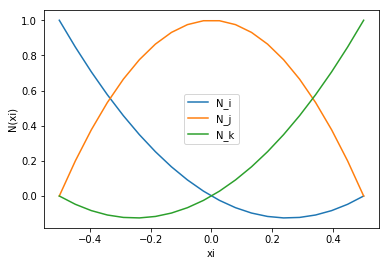

In [24]:
NumberOfPointsToPlot = 20
L=1
xi = np.linspace(-L/2, L/2, NumberOfPointsToPlot)
plt.plot(xi, N(xi,L)[0,0,:], label='N_i')
plt.plot(xi, N(xi,L)[0,1,:], label='N_j')
if TypeElement == 'Beam3': 
    plt.plot(xi, N(xi,L)[0,2,:], label='N_k')
plt.xlabel('xi')
plt.ylabel('N(xi)')
plt.legend()

### Interpolation des déformations et contraintes
Pour un élément poutre en traction/compression, la seule déformation utile est l'allongement axial donné par $\varepsilon = \frac{du}{dx}$.
$$\frac{du}{dx}(\xi) = \left[ \begin{matrix} - \frac{1}{L} & \frac{1}{L} \end{matrix} \right] . \left[ \begin{matrix} u_i \\ u_j \end{matrix} \right] = B(\xi) . q_{el}$$

Pour en déduire l'effort normal dans la poutre, il convient d'utiliser la loi de comportement généralisée :
$\sigma = \frac{ES}{L} \frac{du}{dx}$

Nous définissons donc les fonction matricielles 'B' et 'StressMatrix' respectivement pour l'interpolation des déformations et des contraintes généralisées (effort normal).

In [25]:
if TypeElement == 'Beam2':
    def B(xi, L):
        return np.array([[-1/L + 0*xi, 1/L + 0*xi]])

elif TypeElement == 'Beam3':
    def B(xi, L):
        return np.array([[4*xi/L**2-1/L, -8*xi/L**2, 4*xi/L**2+1/L]])
    
def StressMatrix(xi, L, x0, E, S):
    x = xi+x0 #change of variable: local coordinate is transform into global coordinate to use the function S
    return E*S(x)*B(xi,L)

Remarque : dans la fonction B, le terme '0\*xi' ne sert qu'à retourné un tableau de bonne dimension. 
Pour les éléments d'ordre 1, la valeur retournée ne dépend pas de $\xi$. La fonction garde néanmoins une dépendance en $\xi$ pour permettre l'utilisation d'éléments d'ordre plus élevé.

## Matrice de rigidité élémentaire
Pour calculer la matrice de rigidité élémentaire $K_{el}$, il faut revenir à la définition de l'énergie élastique.
Pour des éléments poutres à 2 noeuds : 
$$E_d = \frac{1}{2} \int_{-\frac{L}{2}}^{\frac{L}{2}} \sigma \varepsilon \, d\xi$$
Et donc en utilisant les interpolations de $\varepsilon$ et $\sigma$:
$$E_d = q_{el}^T \, \frac{1}{2} \underbrace{\left( \int_{-\frac{L}{2}}^{\frac{L}{2}} ES \, B(\xi,L)^T . B(\xi,L) \, d\xi \right)}_{K_{el}} \, q_{el} $$

On commence par définir une fonction pour l'intégration basée sur la méthode des trapèzes dans un soucis de simplicité.

In [26]:
NumberOfIntegrationPoints = 500

def integrate(f, a, b, N):
    x = np.linspace(a, b, N)
    fx = f(x)
    area = np.sum(fx,axis = 0)*(b-a)/N
    return area

Nous avons vu que $K_{el} = \int_{-\frac{L}{2}}^{\frac{L}{2}} dE(\xi,L,E,S) \, d\xi$
avec $dE = ES \, B(\xi,L)^T . B(\xi,L)$.

Nous définons donc la fonction dE que nous intégrons numériquement entre $-\frac{L}{2}$ et $\frac{L}{2}$.
Ces 2 étapes sont inclus dans la fonction GetElementStiffnessMatrix qui renvoit la matrice de rigidité $K_{el}$.

In [27]:
def GetElementStiffnessMatrix(L, x0, E, S, NumberOfIntegrationPoints):
    def dE(xi):
        Sigma = np.transpose( StressMatrix(xi,L,x0,E,S) , (2,1,0) )
        Epsilon = np.transpose( B(xi,L) , (2,0,1) )
        return Sigma @ Epsilon #@ operator = stack of matrix multiplication
    
    return integrate(dE,-L/2,L/2, NumberOfIntegrationPoints)

In [28]:
Kel = GetElementStiffnessMatrix(H/NumberOfElements,0,E,S,NumberOfIntegrationPoints)
print(Kel)

[[ 1.36547184e+09 -1.56321369e+09  1.97741852e+08]
 [-1.56321369e+09  3.12642739e+09 -1.56321369e+09]
 [ 1.97741852e+08 -1.56321369e+09  1.36547184e+09]]


## Assemblage de la matrice de rigidité globale

L'assemblage de la matrice globale se fait simplement avec une boucle sur les éléments en ajoutant la contribution de chaque élément aux noeuds correspondants. 

In [29]:
#Assemble the global stiffness matrix
StiffnessMatrix = np.zeros((NumberOfNodes, NumberOfNodes))
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    print(Crd)
    L = Crd[-1] - Crd[0]
    x0 = (Crd[0] + Crd[1])/2
    Kel = GetElementStiffnessMatrix(L,x0,E,S,NumberOfIntegrationPoints) #not needed if L, E, or S are the same for each element
    StiffnessMatrix[Nodes.reshape(-1,1), Nodes] += Kel   

print(StiffnessMatrix)

[0.         0.83333333 1.66666667]
[1.66666667 2.5        3.33333333]
[3.33333333 4.16666667 5.        ]
[[ 1.36547184e+09 -1.56321369e+09  1.97741852e+08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.56321369e+09  3.12642739e+09 -1.56321369e+09  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.97741852e+08 -1.56321369e+09  2.73094368e+09 -1.56321369e+09
   1.97741852e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.56321369e+09  3.12642739e+09
  -1.56321369e+09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.97741852e+08 -1.56321369e+09
   2.73094368e+09 -1.56321369e+09  1.97741852e+08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.56321369e+09  3.12642739e+09 -1.56321369e+09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.97741852e+08 -1.56321369e+09  1.36547184e+09]]


## Matrice colonne des efforts généralisés


Pour les efforts généralisées, on distingue les efforts ponctuels aux noeuds des efforts linéiques.
On commence par initialiser un vecteur 'ForceVector' contenant uniquement les efforts aux noeuds (ici, un seul effort ponctuel sur le dernier noeuds (noeud 4). 

In [30]:
ForceVector = np.zeros(NumberOfNodes)
ForceVector[-1] = F
print(ForceVector)

[    0.     0.     0.     0.     0.     0. -1000.]


Pour les efforts linéiques, il faut revenir à la définition du travail des efforts exterieurs sur un élément. 
$$W_{ext} = \int_{-\frac{L}{2}}^{\frac{L}{2}} f_l(x) u(\xi) \, d\xi$$
Et donc en utilisant l'interpolation de $u(x)$:
$$W_{ext} = q_{el}^T \, \underbrace{\left( \int_{-\frac{L}{2}}^{\frac{L}{2}} N(\xi,L)^T . f_l(\xi+x_0) \, d\xi \right)}_{F_{el}}  $$

Comme pour la matrice de rigidité globale, nous définissons une fonction $dF = N(\xi,L)^T . f_l(\xi+x0)$ que nous intégrons sur chaque élément pour avoir $F_{el}$, puis nous sommons les contributions de chaque éléments dans une matrice colonne globale (matrice des efforts généralisés). 

In [31]:
#Assemble force vector
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1] - Crd[0]
    x0 = (Crd[0] + Crd[1])/2
    def dF(xi):
        return (fl(xi+x0)*N(xi,L)).transpose(2,0,1)
        
    Fel = integrate(dF, -L/2, L/2, NumberOfIntegrationPoints)
    ForceVector[Nodes] += Fel[0]  
    
print(ForceVector)

[  -99.52111581  -395.70072395  -199.04223163  -395.70072395
  -199.04223163  -395.70072395 -1099.52111581]


## Conditions aux limites et résolution
On définit une matrice G telle que les conditions aux limites s'écrivent : $G q = Q_d$.
Ici nous avons uniquement le premier noeud (noeud 0) qui est bloqué : $u_0=0$.

In [32]:
G = np.zeros((1,NumberOfNodes))
G[:,0] = 1
Qd = np.array([0]) 
print(G)
print(Qd)




[[1. 0. 0. 0. 0. 0. 0.]]
[0]


On construit ensuite le système à résoudre : $M q = V$. 
Les conditions aux limites sont appliquées avec la méthode des multiplicateurs de Lagrange.

In [33]:
nbCL = np.shape(G)[0]
M = np.block([[StiffnessMatrix, -G.T],[G, np.zeros((nbCL, nbCL))]])
print(M)

[[ 1.36547184e+09 -1.56321369e+09  1.97741852e+08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [-1.56321369e+09  3.12642739e+09 -1.56321369e+09  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 1.97741852e+08 -1.56321369e+09  2.73094368e+09 -1.56321369e+09
   1.97741852e+08  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.56321369e+09  3.12642739e+09
  -1.56321369e+09  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.97741852e+08 -1.56321369e+09
   2.73094368e+09 -1.56321369e+09  1.97741852e+08 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.56321369e+09  3.12642739e+09 -1.56321369e+09 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.97741852e+08 -1.56321369e+09  1.36547184e+09 -0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

In [34]:
V = np.block([ForceVector, Qd])
print(V)

[  -99.52111581  -395.70072395  -199.04223163  -395.70072395
  -199.04223163  -395.70072395 -1099.52111581     0.        ]


le système est résolu par une méthode directe (pivot de Gauss). Pour les grands systèmes creux, l'utilisation d'une méthode itérative est en général plus efficace. 

In [35]:
res  = np.linalg.solve(M, V)
U = res[:NumberOfNodes]
R = res[NumberOfNodes:]
print(U) #Nodal displacement
print(R) #Force Reaction

[ 1.28238952e-20 -2.25621746e-06 -4.25930208e-06 -6.00620407e-06
 -7.49997322e-06 -8.73755973e-06 -9.72201340e-06]
[2784.22886675]


## Visualisation
### Visualisation du déplacement


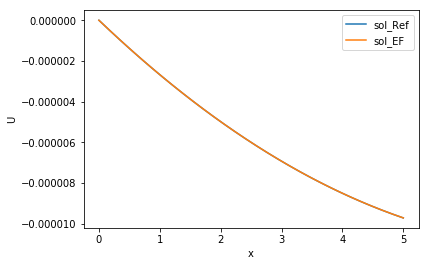

In [36]:
if TypeRadius == 'Constant':
    #Reference solution (only for constant fl and S)
    x = np.linspace(0, H, 10*NumberOfElements)
    plt.plot(x, ((F+fl(x)*H)*x-fl(x)/2*x**2)/(E*S(x)), label='sol_Ref')    
elif TypeRadius == 'Variable':
    #no analytical solution in this case
    pass 

#FE solution
xi = np.linspace(-L/2, L/2, 10)
x_all = []
u_x = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x = np.linspace(Crd[0], Crd[-1], 10)
    u_x = np.hstack((u_x, (N(xi, L).transpose(2,0,1)@U[Nodes])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, u_x, label='sol_EF')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()

### Visualisation de l'effort normal
La solution analytique s'écrit : $\sigma = F+f_l(H-x)$.

Attention, ici $\sigma$ est homogène à une force et pas à une contrainte.
Remarque : F<0 et fl<0.

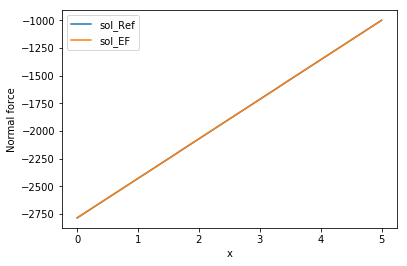

In [37]:
if TypeRadius == 'Constant':
    #Reference solution (only for constant fl and S)
    x = np.linspace(0, H, 10*NumberOfElements)
    plt.plot(x, F+fl(x)*(H-x), label='sol_Ref')
elif TypeRadius == 'Variable':
    #Reference solution (only for linear variation of S and fl)
    x = np.linspace(0, H, 10*NumberOfElements)
    a = (fl(H)-fl(0))/H ; b = fl(0) #fl=ax+b
    plt.plot(x, F + (H**2-x**2)/2*a + (H-x)*b, label='sol_Ref')

#FE solution
xi = np.linspace(-L/2, L/2, 10)
x_all = []
sigma_x = []
for element in range(NumberOfElements):
    Nodes = ConnectionMatrix[element]   
    Crd = NodeCoordinates[Nodes]
    L = Crd[-1]-Crd[0]
    x0 = (Crd[0]+Crd[1])/2
    x = np.linspace(Crd[0], Crd[-1], 10)
    sigma_x = np.hstack((sigma_x, (StressMatrix(xi, L, x0, E, S).transpose(2,0,1)@U[Nodes])[:,0]))
    x_all = np.hstack((x_all, x))

plt.plot(x_all, sigma_x, label='sol_EF')
plt.xlabel('x')
plt.ylabel('Normal force')
plt.legend()

Remarque : La réaction à l'encastrement donnée par le multiplicateur de lagrange $R$ donne la solution exacte car nous sommes dans le cas d'un problème isostatique. 

In [38]:
print(R)
if TypeRadius == 'Constant':
    print(-F-fl(0)*H)
elif TypeRadius == 'Variable':
    a = (fl(H)-fl(0))/H ; b = fl(0) #fl=ax+b
    print(-F - H**2/2*a - H*b)

[2784.22886675]
2784.2288667467765


## Pour aller plus loin
* Modifier le nombre de noeuds et relancer le calcul pour observer la convergence des résultats vers la solution analytique.
* Modifier le type d'élément en 'Beam3' et regarder la différence. Regarder en particulier la solution avec un seul élément. Est-ce que ce résultat était prévisible ?
* Que se passe-t-il si on met moins de points d'intégration ? Par exemple on pourra utiliser 10 points (NumberOfIntegrationPoints = 10) avec des éléments 'Beam3'. On observe alors l'importance d'utiliser une méthode d'intégration précise. En pratique, la méthode de Gauss est souvent utilisée car elle donne une intégration exacte des polynômes.
* Remplacer la Section constante, par une section variable (fonction affine) et donc un force linéique due au poids variable.